# CycleGAN Horse2Zebra

---

In this notebook will learn about Generative Adversarial Networks by implementing a Cycle GAN to transfer styles from Horse to Zebra.

Important: Set the Cloab environment to run on GPU

Author: Ramon Planas

Based on SIMPLE GAN colab from: Albert Pumarola

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1  or classname.find('ConvTranspose2d') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.00, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype)))

## Dataset
Download and prepare dataset


In [0]:
# Download horse2zebra
!mkdir -p ./datasets
!#wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
#!unzip ./datasets/horse2zebra.zip -d ./datasets/

#---------------------------
#Code for Barça-Madrid code
!pip install -U -q PyDrive
#file_id = "1YE0BuojBKjQG6EjBRPP9mgGtsBwo07pe" # 1st dataset
file_id = "10tzYgF-1-7NF7pjAS0r25eY55ZUg_SM4" # new dataset (Nuria)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download file
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('./datasets/barcelona2madrid.zip')

# Unzip dataset
!unzip ./datasets/barcelona2madrid.zip -d ./datasets/

# Rename folders
!mv ./datasets/fcBarcelona2fcRealMadrid_new/ ./datasets/barcelona2madrid
!mv ./datasets/barcelona2madrid/TrainA ./datasets/barcelona2madrid/trainA
!mv ./datasets/barcelona2madrid/TrainB ./datasets/barcelona2madrid/trainB
!mv ./datasets/barcelona2madrid/TestA ./datasets/barcelona2madrid/testA
!mv ./datasets/barcelona2madrid/TestB ./datasets/barcelona2madrid/testB

Archive:  ./datasets/barcelona2madrid.zip
   creating: ./datasets/fcBarcelona2fcRealMadrid_new/
   creating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/601_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/602_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/603_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/604_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/605_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/606_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/607_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/608_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/609_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid_new/TestA/610_fcBarcelona.jpg  
  inflating: ./datasets/fcBarcelon

Generate Data Class

In [0]:
class Horse2ZebraDataset(Dataset):
  """
  Dataset class to load images
  """
  def __init__(self, root_dir, transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    self.root_dir = root_dir
    self.transform = transform
    self.list_images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.list_images[idx])
    image = Image.open(img_name)

    if self.transform:
      image = self.transform(image)

    return image

class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, batch_size, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform
    self.batch_size = batch_size

  def __len__(self):
    if len(self.filelistA) < len(self.filelistB):
      num_img = int(len(self.filelistA)/self.batch_size) * self.batch_size
    else:
      num_img = int(len(self.filelistB)/self.batch_size) * self.batch_size
    return num_img

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB

In [0]:
image_size = 128
batch_size = 20
tf_train = transforms.Compose(
    [#transforms.Resize(image_size, interpolation=0),
     transforms.RandomHorizontalFlip(),
     #transforms.RandomVerticalFlip(),
     transforms.RandomResizedCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )
tf_test = transforms.Compose(
    [transforms.Resize(160, interpolation=0),
     #transforms.RandomHorizontalFlip(),
     #transforms.RandomVerticalFlip(),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

# Horse2Zebra
#horse2zebra_train = TwoDatasets('./datasets/horse2zebra/trainA', './datasets/horse2zebra/trainB', batch_size, transform=tf_train)
#horse2zebra_test  = TwoDatasets('./datasets/horse2zebra/testA',  './datasets/horse2zebra/testB',  batch_size, transform=tf_test)

# Barcelona2Madrid
barcelona2madrid_train = TwoDatasets('./datasets/barcelona2madrid/trainA', './datasets/barcelona2madrid/trainB', batch_size, transform=tf_train)
barcelona2madrid_test  = TwoDatasets('./datasets/barcelona2madrid/testA',  './datasets/barcelona2madrid/testB',  batch_size, transform=tf_test)

## Data Loader
Create a data loader for the MNIST dataset

In [0]:
# Horse2Zebra
#data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
#data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=True)

# Barcelona2Madrid
data_loader_train = torch.utils.data.DataLoader(barcelona2madrid_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(barcelona2madrid_test,  batch_size=batch_size, shuffle=False)

Show some examples

600
180


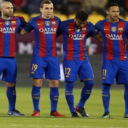

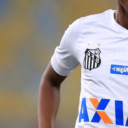

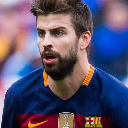

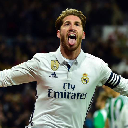

In [0]:
"""
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])
"""

print(len(barcelona2madrid_train))
print(len(barcelona2madrid_test))

display_batch_images(barcelona2madrid_train[0][0])
display_batch_images(barcelona2madrid_train[0][1])
#
display_batch_images(barcelona2madrid_test[0][0])
display_batch_images(barcelona2madrid_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator_simple(torch.nn.Module):
    
    def __init__(self):
        super(Generator_simple, self).__init__()
      
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc1 = nn.Linear(512*8*8, 512)
        self._fc2 = nn.Linear(512, 512*8*8)

        self._deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self._deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        # Image to image
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)

        x = self._fc1(x.view(-1, 512*8*8))
        x = self._fc2(x)

        x = self._deconv1(x.view(x.shape[0], 512, 8, 8))
        x = self._deconv2(x)
        out = self._deconv3(x)

        return out

Generator from CycleGAN paper

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # ENCODING
        self._encoder1 = self.encoder(3, 64, 4)
        self._encoder2 = self.encoder(64, 128, 4)
        self._encoder3 = self.encoder(128, 256, 4)

        # TRANSFORMATION (RESNET)
        self._res1 = self.residual(256, 256, 3)
        self._res2 = self.residual(256, 256, 3)
        self._res3 = self.residual(256, 256, 3)

        # DECODING
        self._decoder1 = self.decoder(256, 128, 4)
        self._decoder2 = self.decoder(128, 64, 4)
        self._decoder3 = self.decoder2(64, 3, 4)

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5)
        )
        return x

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2)
        )
        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5)
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=True),
            nn.Tanh()
        )
        return x 

    def forward(self, x):
        # Encode -> Transform -> Decode
        # Encoding
        x = self._encoder1(x)
        x = self._encoder2(x)
        x = self._encoder3(x)

        # Transformation: Resnet blocks
        a = self._res1(x)
        b = x + a
        c = self._res2(b)
        d = b + c
        e = self._res3(d)
        x = d + e

        # Decoding
        x = self._decoder1(x)
        x = self._decoder2(x)
        x = self._decoder3(x)

        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator_simple(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator_simple, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        out = self._fc(x.view(-1, 512*8*8))

        return out

Discriminator from Cycle GAN paper

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, stride=2, padding=1, bias=True),
            nn.Sigmoid(),
            nn.AdaptiveAvgPool2d(1)
        )

        # Global average pooling !!!
        # Global max pooling !!! (to avoid flatten and linear 4000 to 1)
        # self._fc1: 512 -> 128
        # self._fc2: 128 -> 1
        #self._avg_pool = nn.AdaptiveAvgPool2d(1)

        #self._fc = nn.Sequential(
        #    nn.Linear(int(512*image_size*image_size/(8*8)), 1),
        #    nn.Sigmoid()
        #)
        #self._fc = nn.Sequential(
        #    nn.Linear(int(512*image_size*image_size/(8*8)),128),
        #    #nn.Linear(512,128),
        #    nn.LeakyReLU(0.2),
        #    nn.Linear(128,1),
        #    nn.Sigmoid()
        #)

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        output = self._conv4(x).squeeze()

        #x = self._avg_pool(x).squeeze()
        #output = self._fc(x.view(-1, int(512*image_size*image_size/(8*8))))
        #output = self._fc(x)

        return output

## Model

Now lets create the core of our task, the model. Remember Cycle GANs loss: $\mathcal{L}_{GAN}(G,D_Y,X,Y)=\mathbb{E}_{y\sim p_{data}(y)}\big[logD_Y(y)\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[log(1-D_Y(G(x)))\big]$

$\mathcal{L}_{cyc}(G,F)=\mathbb{E}_{x\sim p_{data}(x)}\big[||F(G(x))-x||_1\big] + \mathbb{E}_{y\sim p_{data}(y)}\big[||G(F(y))-y||_1\big]$

The full objective is:

$\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y) + \mathcal{L}_{GAN}(F,D_X,Y,X) + \lambda\mathcal{L}_{cyc}(G,F)$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizers(self):
        # generators optimizers
        self._opt_genA2B = torch.optim.Adam(self._generatorA2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_genB2A = torch.optim.Adam(self._generatorB2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        # Look for param groups
        
        # discriminators optimizers
        self._opt_discrA = torch.optim.Adam(self._discriminatorA.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_discrB = torch.optim.Adam(self._discriminatorB.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss()# To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()# L1 for Cycle Consistency Loss
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = -1*self._criterionGAN(estim_fakeA, self._label_fake) #self._label_real)
        estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = -1*self._criterionGAN(estim_fakeB, self._label_fake) #self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        #
        loss_gA2B.backward(retain_graph=True)
        loss_gB2A.backward()
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        #
        # optimize discriminator A
        #
        for params in self._discriminatorA.parameters():
          params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_dA.item(), loss_dB.item(), loss_cyc.item()

    def step_fake_samples(self, real_samplesA, real_samplesB):

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        return fake_samplesA2B, fake_samplesB2A, cyc_samplesA, cyc_samplesB

    def step_opt_generator(self, real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A, cyc_samplesA, cyc_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        #for params in self._discriminatorA.parameters():
        #  params.requires_grad = False
        #for params in self._discriminatorB.parameters():
        #  params.requires_grad = False
        with torch.no_grad():
          estim_fakeA = self._discriminatorB(fake_samplesA2B)
          estim_fakeB = self._discriminatorA(fake_samplesB2A)

        #estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        #estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        loss_total = loss_gA2B + loss_gB2A
        #
        loss_total.backward()
        #loss_gA2B.backward()#retain_graph=True)
        #loss_gB2A.backward()
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_cyc.item()

    def step_opt_discriminator(self, real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A):

        # Reset gradients
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        #
        # optimize discriminator A
        #
        #for params in self._discriminatorA.parameters():
        #  params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        #for params in self._discriminatorB.parameters():
        #  params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_dA.item(), loss_dB.item()
        
  

## Train

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_epochs = 200
lambda_cyc = 10
k_gen = 1
k_dis = 5
model = Model(batch_size)
#print(model._generatorA2B)
print(f"Number of parameters GeneratorA2B: {count_parameters(model._generatorA2B)}")
print(f"Number of parameters GeneratorB2A: {count_parameters(model._generatorB2A)}")
print(f"Number of parameters DiscriminatorA: {count_parameters(model._discriminatorA)}")
print(f"Number of parameters DiscriminatorB: {count_parameters(model._discriminatorB)}")



Number of parameters GeneratorA2B: 4860163
Number of parameters GeneratorB2A: 4860163
Number of parameters DiscriminatorA: 1484289
Number of parameters DiscriminatorB: 1484289


In [0]:
g_A2B_loss = []
g_B2A_loss = []
d_A_loss = []
d_B_loss = []
cycle_loss = []

for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        #loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB, lambda_cyc)

        # Generate fake samples
        fake_samplesA2B, fake_samplesB2A, cyc_samplesA, cyc_samplesB = model.step_fake_samples(real_samplesA, real_samplesB)

        # Optimize generators
        if (n_batch) % k_gen == 0:
          loss_gA2B, loss_gB2A, loss_cyc = model.step_opt_generator(real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A, cyc_samplesA, cyc_samplesB, lambda_cyc)
          g_A2B_loss.append(loss_gA2B)
          g_B2A_loss.append(loss_gB2A)
          cycle_loss.append(loss_cyc)
          

        # Optimize discriminators
        if (n_batch) % k_dis == 0:
          loss_dA, loss_dB = model.step_opt_discriminator(real_samplesA, real_samplesB, fake_samplesA2B, fake_samplesB2A)
          d_A_loss.append(loss_dA)
          d_B_loss.append(loss_dB)

        # Adaptive lambda_cyc
        #if loss_cyc > 0.50:
        #  lambda_cyc = 5
        #elif loss_cyc < 0.50 and loss_cyc > 0.25:
        #  lambda_cyc = 2.5
        #elif loss_cyc < 0.25:
        #  lambda_cyc = 0.5

        # Show fake samples
        if n_batch == 10 and (epoch) % 1 == 0:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())
            #
            fake_samplesB = model._generatorB2A(real_samplesB)
            fake_samplesA = model._generatorA2B(fake_samplesB)
            display_batch_images(real_samplesB)
            display_batch_images(fake_samplesB.detach())
            display_batch_images(fake_samplesA.detach())

    # Show current loss
    #if (n_batch) % 100 == 0:
    print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch+1}/{len(data_loader_train)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
    print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")
    #print(g_A2B_loss)

   
plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(g_A2B_loss, label='G_A2B')
plt.plot(g_B2A_loss, label='G_B2A')
plt.legend()
plt.subplot(3,1,2)
plt.plot(d_A_loss, label='D_A')
plt.plot(d_B_loss, label='D_B')
plt.xlabel('Epoch')
plt.ylabel('DiscrLoss')
plt.legend()
plt.subplot(3,1,3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(cycle_loss, label='Cyc')
plt.legend()